# Power-law Fitting
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 11/4/2021|

## Python Imports

In [1]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import fft
from scipy.optimize import curve_fit

# $|m|$ vs. $\Pi$ Data

,Run,⟨𝑚₊⟩,𝜎_𝑚₊,⟨𝑚₋⟩,𝜎_𝑚₋
0,BA/0.01-1024,9.8,0.75,-9.5,1.50
1,BA/0.02-1024,6.8,1.95,-7.3,1.90
2,BA/0.05-1024,3.2,1.25,-4.0,0.50
3,BA/0.10-1024,2.2,0.50,-2.2,0.25


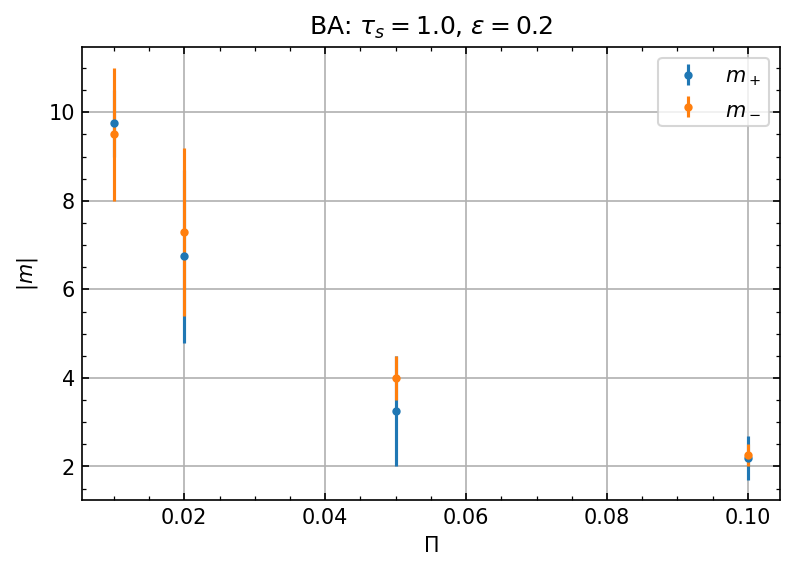

In [4]:
title = 'BA'
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
Pis = np.zeros(len(runs))
rpss = np.asarray([[10.5, 9.0],
                   [8.7, 4.8],
                   [4.5, 2.0],
                   [2.7, 1.7]]) # raw positive slopes
rnss = np.asarray([[-11.0, -8.0],
                   [-9.2, -5.4],
                   [-4.5, -3.5],
                   [-2.5, -2.0]]) # raw negative slopes
μpss, μnss = np.mean(rpss, axis=1), np.mean(rnss, axis=1)
σpss = (np.abs(np.diff(rpss, 1))/2).flatten()
σnss = (np.abs(np.diff(rnss, 1))/2).flatten()

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    Pis[i] = athinput['problem']['duy0']   # global rad. press. grad.
    Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
    τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
    ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio

fig, ax = plt.subplots(dpi=150)
ax.errorbar(Pis, μpss, σpss, fmt='.', label=r'$m_+$')
ax.errorbar(Pis, np.abs(μnss), σnss, fmt='.', label=r'$m_-$')
ax.set(xlabel=r'$\Pi$', ylabel=r'$|m|$',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

df = pd.DataFrame({
    'Run': runs,
    '⟨𝑚₊⟩': μpss,
    '𝜎_𝑚₊': σpss,
    '⟨𝑚₋⟩': μnss,
    '𝜎_𝑚₋': σnss})
df.style.format({
    '⟨𝑚₊⟩': '{:.1f}',
    '𝜎_𝑚₊': '{:.2f}',
    '⟨𝑚₋⟩': '{:.1f}',
    '𝜎_𝑚₋': '{:.2f}',})

# Linear model function: $\log|m|$ vs. $\log\Pi$
## Model Function
Consider a power-law function of the form
$$
y = ax^k,
$$
which is *linear* in log-log space, i.e.,
\begin{aligned}
\log y &= \log a + k\log x\\
v &= b + ku,
\end{aligned}
where
\begin{aligned}
v &= \log y,\\
u &= \log x,\\
b &= \log a.
\end{aligned}

## Error Bars
Consider the respective linear, lower and upper uncertainties $y-\sigma_y$ and $y+\sigma_y$, where $\sigma_y$ is the standard deviation of errors in $y$ data.
The logarithm of these values must respectively correspond to $\log y - \log y_\textrm{err-}$ and $\log y + \log y_\textrm{err+}$ in logarithmic space.
For the lower case, we find
\begin{aligned}
\log y - \log y_\textrm{err-} &= \log(y-\sigma_y)\\
\log\left(\frac{y}{y_\textrm{err-}}\right) &= \log(y-\sigma_y)\\
y_\textrm{err-} &= \frac{y}{y-\sigma_y}.
\end{aligned}
And for the upper case,
\begin{aligned}
\log y + \log y_\textrm{err+} &= \log(y+\sigma_y)\\
\log(yy_\textrm{err-}) &= \log(y+\sigma_y)\\
y_\textrm{err+} &= 1 + \frac{\sigma_y}{y}.
\end{aligned}

## Fit Errors
As the power-law index $k$ is invariant under the log-linear transformation, this parameter's fitting errors are valid in both linear and log-log spaces.
However, the fitting error on $b$ relates to $a$ as
\begin{aligned}
\log(a \pm \sigma_a) &= b \pm \sigma_b\\
a \pm \sigma_a &= 10^{b \pm \sigma_b}\\
\sigma_a &= 10^{b \pm \sigma_b} \mp a.
\end{aligned}
Finally, with $\log a = b$,
$$
\sigma_a = 10^{b \pm \sigma_b} \mp 10^b.
$$

,Run,⟨𝑚₊⟩,𝜎_𝑚₊,⟨𝑚₋⟩,𝜎_𝑚₋
0,BA/0.01-1024,9.8,0.75,-9.5,1.50
1,BA/0.02-1024,6.8,1.95,-7.3,1.90
2,BA/0.05-1024,3.2,1.25,-4.0,0.50
3,BA/0.10-1024,2.2,0.50,-2.2,0.25


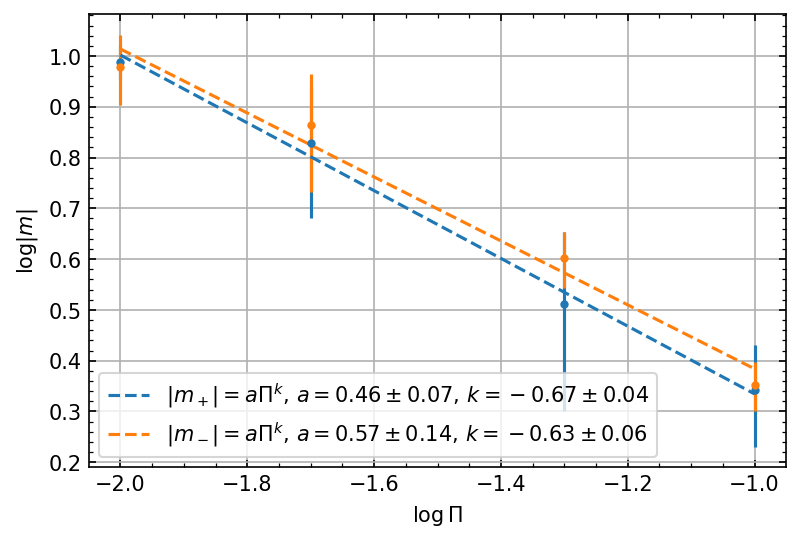

In [3]:
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
Pis = np.zeros(len(runs))
rpss = np.asarray([[10.5, 9.0],
                   [8.7, 4.8],
                   [4.5, 2.0],
                   [2.7, 1.7]]) # raw positive slopes
rnss = np.asarray([[-11.0, -8.0],
                   [-9.2, -5.4],
                   [-4.5, -3.5],
                   [-2.5, -2.0]]) # raw negative slopes
μpss, μnss = np.mean(rpss, axis=1), np.mean(rnss, axis=1)
σpss = (np.abs(np.diff(rpss, 1))/2).flatten()
σnss = (np.abs(np.diff(rnss, 1))/2).flatten()
yperru = np.ones(σpss.size) + σpss/μpss
yperrl = μpss/(μpss - σpss)
ynerru = np.ones(σnss.size) + σnss/np.abs(μnss)
ynerrl = np.abs(μnss)/(np.abs(μnss) - σnss)

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    Pis[i] = athinput['problem']['duy0']  # global rad. press. grad.

func = lambda u, b, k : b + k*u # log(a) + k*log(x)
ppopt, ppcov = curve_fit(func, np.log10(Pis), np.log10(μpss))
npopt, npcov = curve_fit(func, np.log10(Pis), np.log10(np.abs(μnss)))
pperr, nperr = np.sqrt(np.diag(ppcov)), np.sqrt(np.diag(npcov))
pσa = 10**(ppopt[0] + pperr[0]) - 10**ppopt[0]
nσa = 10**(npopt[0] + nperr[0]) - 10**npopt[0]
plabel = r'$|m_+|=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        10**ppopt[0], pσa, ppopt[1], pperr[1])
nlabel = r'$|m_-|=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        10**npopt[0], nσa, npopt[1], nperr[1])

fig, ax = plt.subplots(dpi=150)
ax.errorbar(np.log10(Pis), np.log10(μpss), np.log10([yperrl, yperru]), fmt='.')
ax.errorbar(np.log10(Pis), np.log10(np.abs(μnss)), np.log10([ynerrl, ynerru]),
            fmt='.')
ax.plot(np.log10(Pis), func(np.log10(Pis), *ppopt), ls='--', color='tab:blue',
        label=plabel)
ax.plot(np.log10(Pis), func(np.log10(Pis), *npopt), ls='--', color='tab:orange',
        label=nlabel)
ax.set(xlabel=r'$\log\Pi$', ylabel=r'$\log|m|$')
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

df = pd.DataFrame({
    'Run': runs,
    '⟨𝑚₊⟩': μpss,
    '𝜎_𝑚₊': σpss,
    '⟨𝑚₋⟩': μnss,
    '𝜎_𝑚₋': σnss})
df.style.format({
    '⟨𝑚₊⟩': '{:.1f}',
    '𝜎_𝑚₊': '{:.2f}',
    '⟨𝑚₋⟩': '{:.1f}',
    '𝜎_𝑚₋': '{:.2f}',})

**NOTE**:
- Unsure how to pass errors to [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) (e.g., a 1-D `sigma` should contain values of standard deviations of errors in `ydata`).

# Power-law model function

,Run,⟨𝑚₊⟩,𝜎_𝑚₊,⟨𝑚₋⟩,𝜎_𝑚₋
0,BA/0.01-1024,9.8,0.75,-9.5,1.50
1,BA/0.02-1024,6.8,1.95,-7.3,1.90
2,BA/0.05-1024,3.2,1.25,-4.0,0.50
3,BA/0.10-1024,2.2,0.50,-2.2,0.25


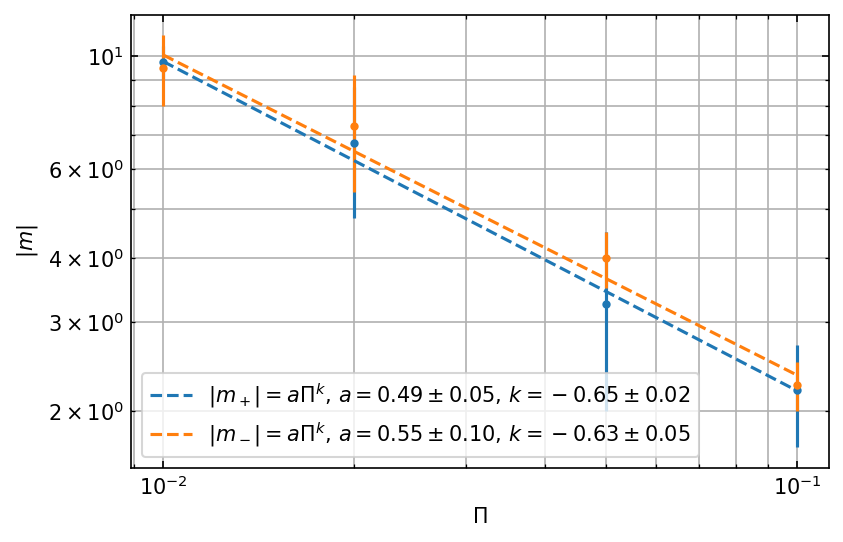

In [155]:
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
Pis = np.zeros(len(runs))
rpss = np.asarray([[10.5, 9.0],
                   [8.7, 4.8],
                   [4.5, 2.0],
                   [2.7, 1.7]]) # raw positive slopes
rnss = np.asarray([[-11.0, -8.0],
                   [-9.2, -5.4],
                   [-4.5, -3.5],
                   [-2.5, -2.0]]) # raw negative slopes
μpss, μnss = np.mean(rpss, axis=1), np.mean(rnss, axis=1)
σpss = (np.abs(np.diff(rpss, 1))/2).flatten()
σnss = (np.abs(np.diff(rnss, 1))/2).flatten()

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    Pis[i] = athinput['problem']['duy0']  # global rad. press. grad.

func = lambda x, a, k : a*x**k # power-law model function
ppopt, ppcov = curve_fit(func, Pis, μpss, sigma=σpss)
npopt, npcov = curve_fit(func, Pis, np.abs(μnss), sigma=σnss)
pperr, nperr = np.sqrt(np.diag(ppcov)), np.sqrt(np.diag(npcov))
plabel = r'$|m_+|=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        ppopt[0], pperr[0], ppopt[1], pperr[1])
nlabel = r'$|m_-|=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        npopt[0], nperr[0], npopt[1], nperr[1])

fig, ax = plt.subplots(dpi=150)
ax.errorbar(Pis, μpss, σpss, fmt='.')
ax.errorbar(Pis, np.abs(μnss), σnss, fmt='.')
ax.plot(Pis, func(Pis, *ppopt), ls='--', color='tab:blue', label=plabel)
ax.plot(Pis, func(Pis, *npopt), ls='--', color='tab:orange', label=nlabel)
ax.set(xlabel=r'$\Pi$', ylabel=r'$|m|$', xscale='log', yscale='log')
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    '⟨𝑚₊⟩': μpss,
    '𝜎_𝑚₊': σpss,
    '⟨𝑚₋⟩': μnss,
    '𝜎_𝑚₋': σnss})
df.style.format({
    '⟨𝑚₊⟩': '{:.1f}',
    '𝜎_𝑚₊': '{:.2f}',
    '⟨𝑚₋⟩': '{:.1f}',
    '𝜎_𝑚₋': '{:.2f}',})